 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="https://192.168.0.100/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/data_augmentation_catsdogs.ipynb#Cats-and-Dogs-(1):-Aumentando-os-dados" data-toc-modified-id="Cats-and-Dogs-(1):-Aumentando-os-dados-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cats and Dogs (1): Aumentando os dados</a></span><ul class="toc-item"><li><span><a href="https://192.168.0.100/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/data_augmentation_catsdogs.ipynb#Dataset" data-toc-modified-id="Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="https://192.168.0.100/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/data_augmentation_catsdogs.ipynb#Data-augmentation" data-toc-modified-id="Data-augmentation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data augmentation</a></span></li><li><span><a href="https://192.168.0.100/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/data_augmentation_catsdogs.ipynb#Definição-do-modelo-de-treinamento" data-toc-modified-id="Definição-do-modelo-de-treinamento-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Definição do modelo de treinamento</a></span></li><li><span><a href="https://192.168.0.100/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/data_augmentation_catsdogs.ipynb#Treinamento" data-toc-modified-id="Treinamento-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Treinamento</a></span></li><li><span><a href="https://192.168.0.100/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/data_augmentation_catsdogs.ipynb#Treinamento-sem-aumento-de-dados" data-toc-modified-id="Treinamento-sem-aumento-de-dados-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Treinamento sem aumento de dados</a></span></li><li><span><a href="https://192.168.0.100/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/data_augmentation_catsdogs.ipynb#Aprendizados-com-este-notebook" data-toc-modified-id="Aprendizados-com-este-notebook-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Aprendizados com este notebook</a></span></li></ul></li></ul></div>

# Cats and Dogs (1): Aumentando os dados

Este é o primeiro de dois notebooks sobre *data augmentation*, *transfer learning* e *fine tunning*.

É apresentada abaixo a técnica de *data augmentation*.

Neste notebook utilizam-se uma rede convolucional com max-pooling e uma rede densa no final.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import os, glob
import PIL.Image

import numpy as np
import torch
from torch import nn
import torch.utils.data
import torch.optim.lr_scheduler
import torchvision

from lib import pytorch_trainer as ptt

## Dataset

O dataset foi obtido de uma competição do Kaggle, https://www.kaggle.com/c/dogs-vs-cats/data.
Utilizaremos neste exemplo as primeiras 1000 imagens de gatos e cachorros como conjunto de treinamento, totalizando 2000 imagens. Para validação usamos as 400 imagens seguintes de cachorros e gatos. O nosso dataset está organizado da seguinte forma:

    /data/datasets/catsdogs_fewsamples/
        train/
            dogs/
                dog.0.jpg
                dog.1.jpg
                ...
                dog.999.jpg
            cats/
                cat.0.jpg
                cat.1.jpg
                ...
                cat.999.jpg
        validation/
            dogs/
                dog.1000.jpg
                dog.1001.jpg
                ...
                dog.1399.jpg
            cats/
                cat.1000.jpg
                cat.1001.jpg
                ...
                cat.1399.jpg
            

In [2]:
class CatsDogsDataset(torch.utils.data.Dataset):
    def __init__(self, rootdir, train=True, transform=None):
        self.train = train
        self.transform = transform
        if self.train:
            self.dirpath = os.path.join(rootdir, 'train')
        else:
            self.dirpath = os.path.join(rootdir, 'validation')
        print(self.dirpath)
        self.l_filepaths = [fp for fp in sorted(glob.glob(os.path.join(self.dirpath, '**'), recursive=True))
                          if fp[-4:].lower() == '.jpg']
    def __len__(self):
        return len(self.l_filepaths)
    def __getitem__(self, index):
        fp = self.l_filepaths[index]
#         out = np.float32(os.path.basename(fp)[:3].lower() == 'dog')
        out = int(os.path.basename(fp)[:3].lower() == 'dog')
        inp = PIL.Image.open(fp)
        if self.transform is not None:
            inp = self.transform(inp)
        return inp, out

## Data augmentation

/data/datasets/catsdogs_fewsamples/train
/data/datasets/catsdogs_fewsamples/validation


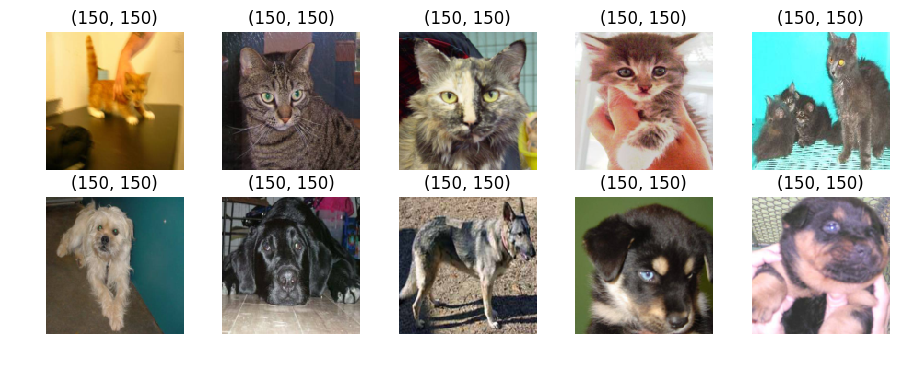

In [3]:
rootdir = '/data/datasets/catsdogs_fewsamples'
size_large = (160, 160)
size_final = (150, 150)
transf_comp_train = torchvision.transforms.Compose([torchvision.transforms.Scale(size=size_large),
                                                    torchvision.transforms.RandomCrop(size=size_final),
                                                    torchvision.transforms.RandomHorizontalFlip(),
                                                    torchvision.transforms.ToTensor()])

transf_comp_valid = torchvision.transforms.Compose([torchvision.transforms.Scale(size=size_final),
                                                    torchvision.transforms.ToTensor()])

dataset_train = CatsDogsDataset(rootdir, train=True, transform=transf_comp_train)
dataset_valid = CatsDogsDataset(rootdir, train=False, transform=transf_comp_valid)

l_imgs = list()
toPIL = torchvision.transforms.ToPILImage()
for idx in list(range(5)) + list(range(-5, 0)):
    l_imgs.append(toPIL(dataset_train[idx][0]))

fig = plt.figure(figsize=(11, 4), dpi=100)
for idx, img in enumerate(l_imgs):
    ax = fig.add_subplot(2, 5, 1 + idx)
    ax.imshow(img)
    ax.set_title('{}'.format(img.size))
    ax.axis('off')
plt.show()

In [4]:
batch_size = 200

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

## Definição do modelo de treinamento

In [5]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3))
        self.relu1 = nn.ReLU()
        self.maxp1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3))
        self.relu2 = nn.ReLU()
        self.maxp2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.relu3 = nn.ReLU()
        self.maxp3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.dens1 = nn.Linear(in_features=64*17*17, out_features=64)
        self.relu4 = nn.ReLU()
        self.drop1 = nn.Dropout(0.5)
        self.dens2 = nn.Linear(in_features=64, out_features=2)
        self.relu5 = nn.ReLU()

    def forward(self, x):        # input:  amostras x  3 x 150 x 150
        x = self.conv1(x)        # output: amostras x 32 x 148 x 148
        x = self.relu1(x)
        x = self.maxp1(x)        # output: amostras x 32 x  74 x  74

        x = self.conv2(x)        # output: amostras x 32 x  72 x  72
        x = self.relu2(x)
        x = self.maxp2(x)        # output: amostras x 32 x  36 x  36

        x = self.conv3(x)        # output: amostras x 64 x  34 x  34
        x = self.relu3(x)
        x = self.maxp3(x)        # output: amostras x 64 x  17 x  17

        x = x.view(-1, 64*17*17) # output: amostras x (64 * 17 * 17)
        x = self.dens1(x)        # output: amostras x 64
        x = self.relu4(x)
        x = self.drop1(x)
        x = self.dens2(x)        # output: amostras x 2
        x = self.relu5(x)

        return x.view(-1, 2)     # output: amostras x 1 x 2

model_augm = MyModel()
if torch.cuda.is_available():
    model_augm.cuda()

## Treinamento

In [7]:
n_epochs = 50
# optm = torch.optim.Adam(params=model_augm.parameters(), lr=0.001, betas=(0.9, 0.999))
# optm = torch.optim.Adam(params=model_augm.parameters(), lr=1.e-5, betas=(0.9, 0.999))
optm = torch.optim.RMSprop(params=model_augm.parameters(), lr=1.e-4, alpha=.9, momentum=.9)
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)
cb_chkpt = ptt.ModelCheckpoint('../../models/data_augmentation_catsdogs', reset=True, verbose=1)

trainer_augm = ptt.DeepNetTrainer(model         = model_augm,
                                  criterion     = nn.CrossEntropyLoss(),
                                  optimizer     = optm,
                                  lr_scheduler  = schd,
                                  callbacks = [cb_chkpt, ptt.AccuracyMetric(), ptt.PrintCallback()])

train = True
if train:
    trainer_augm.fit_loader(n_epochs, loader_train, loader_valid)
else:
    trainer_augm.load_state('/data/models/data_augmentation_catsdogs')

Start training for 50 epochs
  1:   7.5s   T: 0.69469 0.50550   V: 0.69315 0.50000 best
  2:   7.1s   T: 0.69416 0.50100   V: 0.69315 0.50000 
  3:   7.1s   T: 0.69300 0.51550   V: 0.69310 0.51000 best
  4:   7.1s   T: 0.69326 0.50800   V: 0.68763 0.50000 best
  5:   7.1s   T: 0.68863 0.50550   V: 0.68310 0.50250 best
  6:   7.1s   T: 0.68470 0.55550   V: 0.68225 0.54250 best
  7:   7.1s   T: 0.67966 0.56400   V: 0.67153 0.61500 best
  8:   7.1s   T: 0.66966 0.59650   V: 0.65079 0.62500 best
  9:   7.1s   T: 0.65544 0.63050   V: 0.66999 0.57500 
 10:   7.2s   T: 0.65017 0.64000   V: 0.64241 0.64250 best
 11:   7.2s   T: 0.63223 0.65200   V: 0.63111 0.63625 best
 12:   7.1s   T: 0.63588 0.64950   V: 0.62959 0.64375 best
 13:   7.2s   T: 0.61162 0.67450   V: 0.62311 0.65500 best
 14:   7.2s   T: 0.60764 0.67300   V: 0.62624 0.62875 
 15:   7.1s   T: 0.59745 0.68650   V: 0.62627 0.63500 
 16:   7.1s   T: 0.58294 0.69350   V: 0.59307 0.67750 best
 17:   7.2s   T: 0.57416 0.70300   V: 0.584

In [8]:
def show_history(trainer):
    idx = np.argmin(trainer.metrics['valid']['losses'])
    fig = plt.figure(figsize=(10, 4), dpi=100)
    ax = fig.add_subplot(1, 2, 1)
    a_epochs = np.arange(1, 1 + len(trainer.metrics['train']['losses']))
    ax.plot(a_epochs, trainer.metrics['train']['losses'], label='training')
    a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['losses']))
    ax.plot(a_epochs, trainer.metrics['valid']['losses'], label='validation')
    ax.set_title('best validation loss: {:.2f}'.format(trainer.metrics['valid']['losses'][idx]))
    ax.plot(idx + 1, trainer.metrics['valid']['losses'][idx], 'kx')
    ax.legend()
    ax.grid(True)

    ax = fig.add_subplot(1, 2, 2)
    a_epochs = np.arange(1, 1 + len(trainer.metrics['train']['acc']))
    ax.plot(a_epochs, trainer.metrics['train']['acc'], label='training')
    a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['acc']))
    ax.plot(a_epochs, trainer.metrics['valid']['acc'], label='validation')
    ax.set_title('best loss\' validation accuracy: {:.2f}'.format(trainer.metrics['valid']['acc'][idx]))
    ax.plot(idx + 1, trainer.metrics['valid']['acc'][idx], 'kx')
    ax.legend()
    ax.grid(True)
    plt.show()

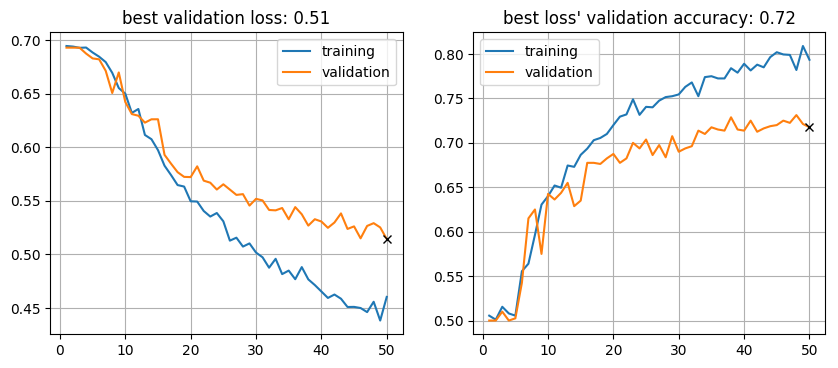

In [9]:
show_history(trainer_augm)

## Treinamento sem aumento de dados

In [16]:
transf_comp_train = torchvision.transforms.Compose([torchvision.transforms.Scale(size=size_final),
                                                    torchvision.transforms.ToTensor()])

transf_comp_valid = torchvision.transforms.Compose([torchvision.transforms.Scale(size=size_final),
                                                    torchvision.transforms.ToTensor()])

dataset_train = CatsDogsDataset(rootdir, train=True, transform=transf_comp_train)
dataset_valid = CatsDogsDataset(rootdir, train=False, transform=transf_comp_valid)

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

model_noaugm = MyModel()
if torch.cuda.is_available():
    model_noaugm.cuda()

optm = torch.optim.Adam(params=model_noaugm.parameters(), lr=1.e-4, betas=(0.9, 0.999))
# optm = torch.optim.RMSprop(params=model_augm.parameters(), lr=1.e-4, alpha=.9, momentum=.9)
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)

trainer_noaugm = ptt.DeepNetTrainer(model         = model_noaugm,
                                    criterion     = nn.CrossEntropyLoss(),
                                    optimizer     = optm,
                                    lr_scheduler  = schd,
                                    callbacks = [ptt.AccuracyMetric(), ptt.PrintCallback()])

trainer_noaugm.fit_loader(n_epochs, loader_train, loader_valid)

/data/datasets/catsdogs_fewsamples/train
/data/datasets/catsdogs_fewsamples/validation
Start training for 50 epochs
  1:   7.1s   T: 0.69420 0.50000   V: 0.69267 0.53625 best
  2:   7.1s   T: 0.69274 0.51200   V: 0.69263 0.59625 best
  3:   7.1s   T: 0.69173 0.52450   V: 0.69117 0.50000 best
  4:   7.1s   T: 0.69147 0.51450   V: 0.68956 0.52625 best
  5:   7.1s   T: 0.68978 0.54150   V: 0.68794 0.53000 best
  6:   7.1s   T: 0.68813 0.52700   V: 0.68689 0.58125 best
  7:   7.1s   T: 0.68649 0.55400   V: 0.68433 0.56125 best
  8:   7.1s   T: 0.68231 0.56250   V: 0.68101 0.53500 best
  9:   7.1s   T: 0.67997 0.57000   V: 0.67839 0.61125 best
 10:   7.1s   T: 0.67472 0.57000   V: 0.67430 0.59250 best
 11:   7.1s   T: 0.67188 0.60450   V: 0.67138 0.59000 best
 12:   7.1s   T: 0.66908 0.60700   V: 0.66851 0.59875 best
 13:   7.1s   T: 0.66338 0.61850   V: 0.66560 0.61125 best
 14:   7.1s   T: 0.66150 0.62200   V: 0.66284 0.61125 best
 15:   7.1s   T: 0.65958 0.63050   V: 0.66124 0.59500 best

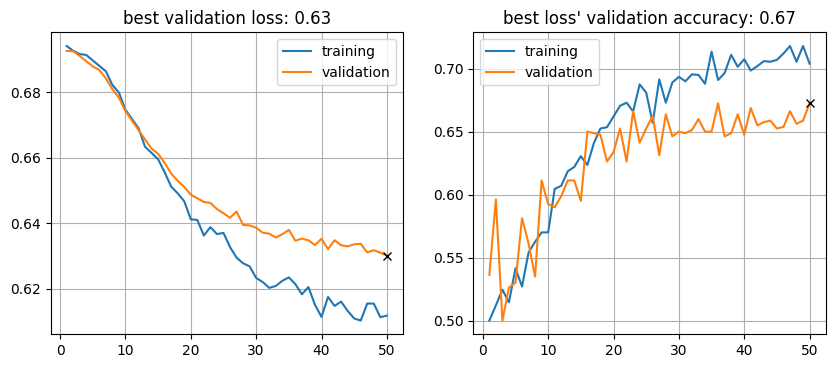

In [18]:
show_history(trainer_noaugm)

## Aprendizados com este notebook

1. Dataset - o PyTorch possui um gerador sintético de dados onde transformações aleatórias são aplicadas no conjunto de treinamento. Esta transformação está sendo aplicada *on the fly*. É uma forma de regularização, permitindo maior generalização do classificador. O treinamento da rede com o gerador de dados resulta em um valor de accuracy nos dados de validação de 76%.
2. O treinamento desta rede sem o uso do gerador aleatório de transformações faz com que a rede sofra overfitting rapidamente, com o resultado para o conjunto de treinamento melhorando mais rapidamente, mas sem melhora para o conjunto de validação.